## Setup


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load the data: the Cats vs Dogs dataset


In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   164M      0  0:00:04  0:00:04 --:--:--  167M


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [4]:
!ls PetImages


Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [5]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


## Generate a `Dataset`


In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.1,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.1,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 21069 files for training.
Found 23410 files belonging to 2 classes.
Using 2341 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


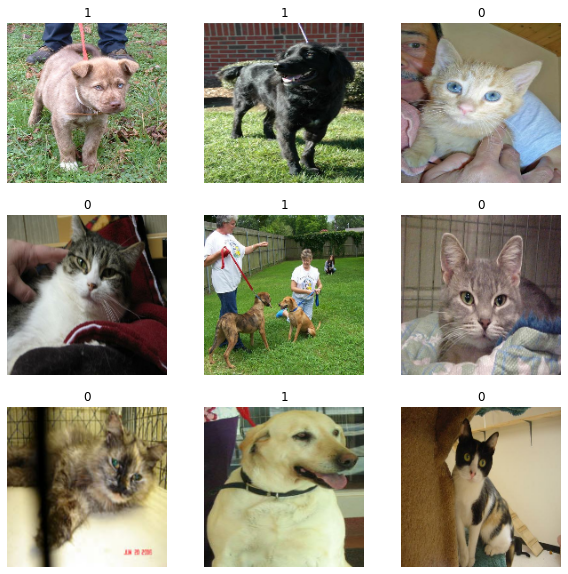

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


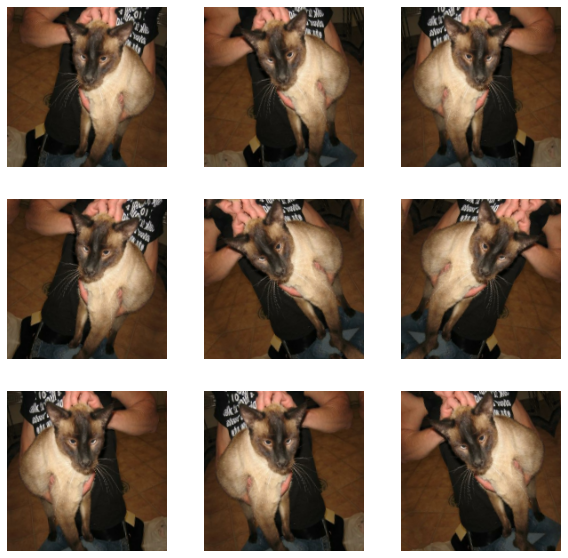

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


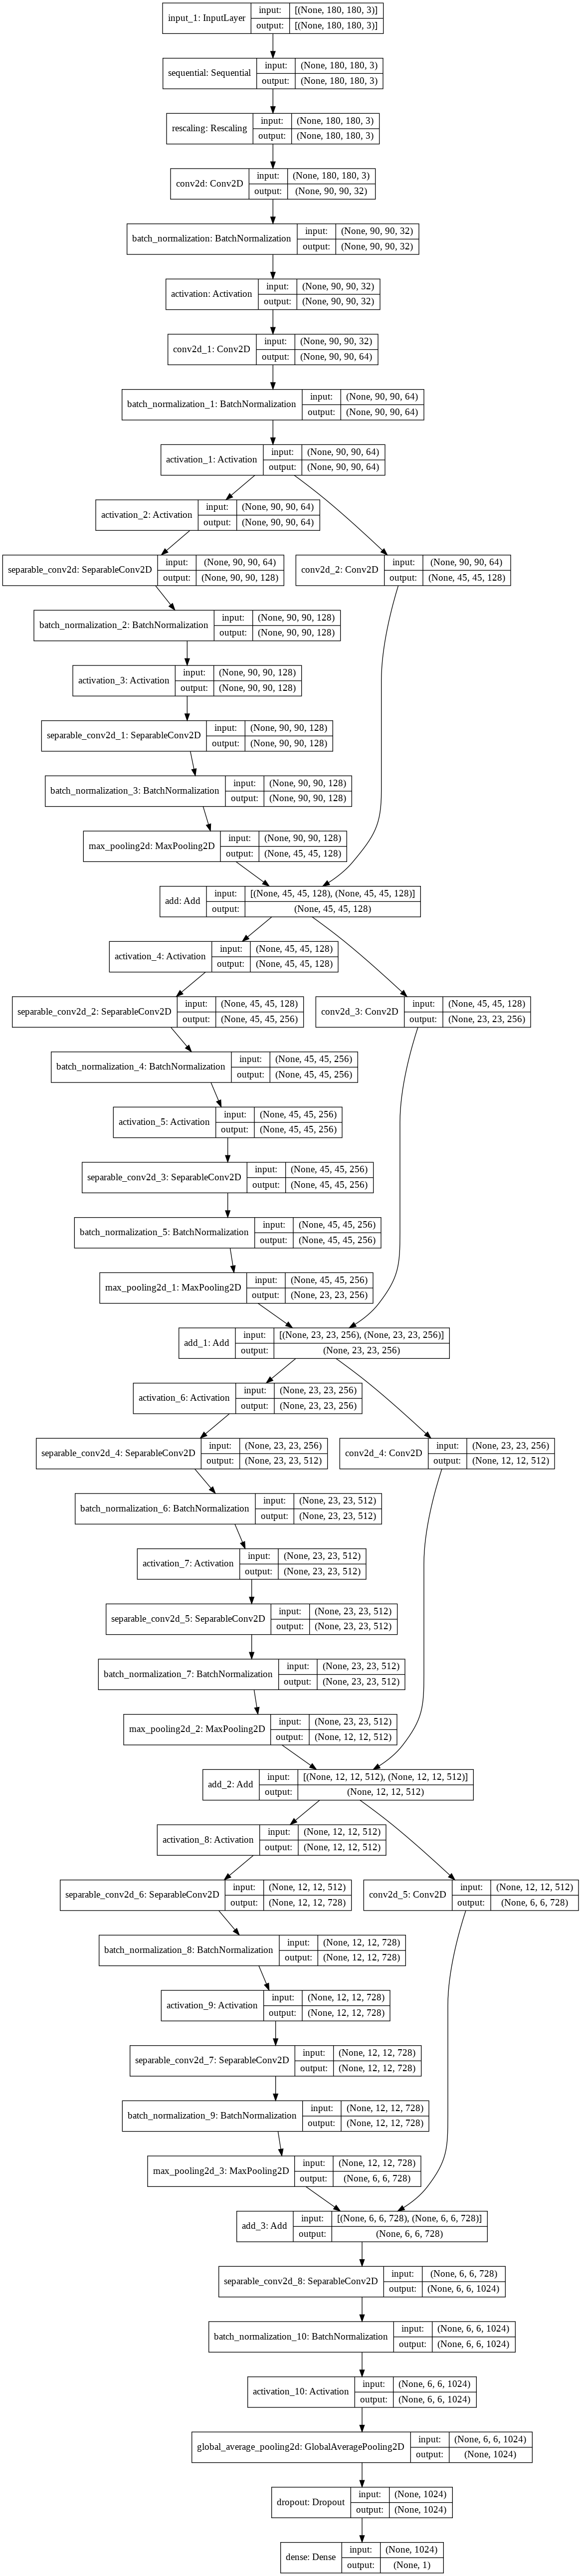

In [11]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Train the model


In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
659/659 [==============================] - 372s 508ms/step - loss: 0.6127 - accuracy: 0.6710 - val_loss: 0.5076 - val_accuracy: 0.7582


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
659/659 [==============================] - 334s 506ms/step - loss: 0.4444 - accuracy: 0.7935 - val_loss: 0.9207 - val_accuracy: 0.6352
Epoch 3/50
659/659 [==============================] - 333s 505ms/step - loss: 0.3409 - accuracy: 0.8528 - val_loss: 0.3801 - val_accuracy: 0.8372
Epoch 4/50
659/659 [==============================] - 333s 505ms/step - loss: 0.2642 - accuracy: 0.8871 - val_loss: 0.2113 - val_accuracy: 0.9158
Epoch 5/50
659/659 [==============================] - 335s 507ms/step - loss: 0.2207 - accuracy: 0.9076 - val_loss: 0.2354 - val_accuracy: 0.8971
Epoch 6/50
659/659 [==============================] - 334s 507ms/step - loss: 0.1961 - accuracy: 0.9192 - val_loss: 0.2888 - val_accuracy: 0.8919
Epoch 7/50
659/659 [==============================] - 334s 507ms/step - loss: 0.1862 - accuracy: 0.9218 - val_loss: 0.2063 - val_accuracy: 0.9197
Epoch 8/50
659/659 [==============================] - 334s 506ms/step - loss: 0.1675 - accuracy: 0.9320 - val_loss: 0.1588 -

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
